# Imports

In [1]:
# ¡¡¡ Conectar con Google Drive !!!

# Se instala e importa import_ipynb para poder acceder a clases/funciones de otros notebooks
!pip install -q import-ipynb

# Se cambia al directorio donde esté el notebook con las clases a importar
%cd "/content/drive/MyDrive/Colab_Notebooks"

#!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install -q -U albumentations

!pip install -q torchmetrics

/content/drive/MyDrive/Colab_Notebooks
     |████████████████████████████████| 102 kB 6.7 MB/s 
     |████████████████████████████████| 37.1 MB 51 kB/s 
     |████████████████████████████████| 282 kB 5.3 MB/s 


In [2]:
# Manejo y representación de datos
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Pytorch 
import torch
from torch import Tensor
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

# Dataset y Dataloader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset , DataLoader

# Transformaciones
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.transform import resize

# Modelos
import import_ipynb
from models import Generator, Discriminator, FeatureExtractor

# Métricas
from torchmetrics.functional import ssim
from torchmetrics.functional import psnr
from torchmetrics.functional import mean_squared_error as mse



# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

importing Jupyter notebook from models.ipynb


#Rutas y dataframe

In [3]:
img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/' # Carpeta que contiene las imágenes

# División en entrenamiento y validación
df = pd.DataFrame(os.listdir(img_fol), columns = ['name'])       # Se estructura de forma tabular el contenido de la carpeta 'img_fol'
df = df.iloc[:2000]    # Se reduce el dataframe a 2000 imagenes
df_train, df_val = train_test_split(df, test_size=.2, random_state=42, shuffle=True, stratify=None) 

# Tras realizar la división, es necesario reiniciar los índices
df_train = df_train.reset_index()
df_val = df_val.reset_index()

print(f"Total: {len(df)} -- Entrenamiento: {len(df_train)} -- Validación: {len(df_val)}")


Total: 2000 -- Entrenamiento: 1600 -- Validación: 400


#Dataset y dataloader

In [4]:
class CarDataset(Dataset):
    def __init__(self, df, transforms = None):
        # self.df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/carvana/train_masks.csv')
        self.df = df 
        self.transforms = transforms
        self.img_fol= '/content/drive/MyDrive/Colab_Notebooks/carvana/train/'
        self.mask_fol = '/content/drive/MyDrive/Colab_Notebooks/carvana/train_masks/' 
       

    def __getitem__(self, idx):
        img_name=self.df['name'][idx]
        img_path=os.path.join(self.img_fol,img_name)    # Ruta completa imagen

        img_HR = cv2.imread(img_path)      # Se carga la imagen
        img_HR= cv2.cvtColor(img_HR, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img_HR = self.transforms(image=img_HR)['image']

        # Factor de escala x4 en cada dimensión. Se mantiene el nº de canales
        img_LR = resize(img_HR.numpy(), (3,img_HR.shape[1]//4,img_HR.shape[2]//4), anti_aliasing=True)
        img_LR = torch.from_numpy(img_LR)
        
        # Se realiza una interpolación bicúbica para tener las mismas dimensiones que en la imagen original
        # img_LR = cv2.resize(img_LR.transpose(1,2,0), (img_HR.shape[1],img_HR.shape[2]), interpolation = cv2.INTER_CUBIC).transpose(2,0,1)

        # Se normaliza entre 0 y 1 para plotear  
        img_HR = ((img_HR + img_HR.min().abs())/(img_HR + img_HR.min().abs()).max())
        img_LR = ((img_LR + img_LR.min().abs())/(img_LR + img_LR.min().abs()).max())
        
        return img_HR, img_LR

    def __len__(self):
        return len(self.df)

In [5]:
# Transformaciones
transforms = A.Compose([
            A.Resize(256, 256),
            A.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

# Datasets de entrenamiento y evaluación
carDatasetTrain = CarDataset(df=df_train, transforms=transforms)
carDatasetval = CarDataset(df=df_val, transforms=transforms)

# Dataloaders de entrenamiento y evaluación
train_dataloader = DataLoader(carDatasetTrain, batch_size=4,
                        shuffle=True, num_workers=0)
val_dataloader = DataLoader(carDatasetval, batch_size=4,
                        shuffle=False, num_workers=0) # El dataloader de validación es fijo, no debe tener shuffle

In [ ]:
img_HR, img_LR = next(iter(train_dataloader))
print(img_HR.shape, img_LR.shape)
bs = img_HR.shape[0]
plt.figure(figsize=(15,15))
print(img_LR.shape)
for i in range(bs):
    plt.subplot(bs,2,(2*i+1))
    plt.title(f"Imagen con transformaciones")
    plt.imshow(img_HR[i].numpy().transpose(1,2,0))
    plt.subplot(bs,2,(2*i+2))
    plt.title(f"Imagen submuestreada")
    plt.imshow(img_LR[i].numpy().transpose(1,2,0))

In [6]:
# Se instancian los modelos y se envían a la gpu si está disponible
generator = Generator().to(device)                # Generador
discriminator = Discriminator().to(device)        # Discriminador
feature_extractor = FeatureExtractor().to(device) # 

# Si hay modelos guardados, se cargan
if os.path.exists('/content/drive/MyDrive/Colab_Notebooks/saved_models/generator.pth'):
    generator.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/saved_models/generator.pth')) # Se cargan los pesos del modelo

if os.path.exists('/content/drive/MyDrive/Colab_Notebooks/saved_models/discriminator.pth'):
    discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/saved_models/discriminator.pth')) # Se cargan los pesos del modelo


# Funciones de pérdida
pixel_criterion = torch.nn.MSELoss().to(device)
content_criterion = torch.nn.MSELoss().to(device)
adversarial_criterion = torch.nn.MSELoss().to(device)     # Adversarial loss.

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_P = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.9, 0.999))  

cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [7]:
def train_generator(epoch, epochs, tloader):

    # Se calcula el número de batches de entrenamiento
    batches = len(train_dataloader)

    # Se establece el generador en modo entrenamiento
    generator.train()

    tloader.set_description(f'GENERATOR TRAIN - EPOCH: [{epoch+1}/{epochs}]')

    # Se inicializan a 0 la variable que almacenarán la loss
    # obtenida en cada batch
    epoch_g_loss = 0

    for hr, lr in tloader:
        # Los batches de imágenes se envían a la GPU si está disponible
        lr, hr= lr.to(device), hr.to(device)

        # Se ponen a cero los gradientes del generador
        optimizer_G.zero_grad()

        # Se obtiene la imagen SR
        sr = generator(lr)

        # Calculate the difference between the super-resolution image and the high-resolution image at the pixel level.
        pixel_loss = pixel_criterion(sr, hr)
        epoch_g_loss += pixel_loss.item()

        # Back propagation
        pixel_loss.backward()

        # Actualización de los pesos del generador
        optimizer_P.step()

        tloader.set_postfix(G_loss=pixel_loss.item())
        return [(epoch_g_loss/batches)]


def train_adversarial(epoch, epochs, tloader):
    # Se calcula el número de batches de entrenamiento
    batches = len(train_dataloader)

    # Se establece la red adversarial en modo entrenamiento
    discriminator.train()
    generator.train()

    tloader.set_description(f'ADVERSARIAL TRAIN - EPOCH: [{epoch+1}/{epochs}]')

    # Se inicializan a 0 las variables que almacenarán las métricas   
    # obtenidas en cada batch
    epoch_d_loss, epoch_perceptual_loss, epoch_psnr, epoch_ssim, epoch_rmse = 0,0,0,0,0

    for hr, lr in tloader:

        # Los batches de imágenes se envían a la GPU si está disponible
        lr, hr= lr.to(device), hr.to(device)

        # Cantidad de imágenes que forman un batch
        label_size = lr.size(0)

        # Se crean las etiquetas. Se establecen en 1 para el caso real, y en 0 para el caso falso.
        real_label = Tensor(np.ones((lr.size(0), *discriminator.output_shape)))
        fake_label = Tensor(np.zeros((lr.size(0), *discriminator.output_shape)))

        # Se ponen a cero los gradientes del discriminador
        optimizer_D.zero_grad()

        # Se calcula la pérdida del discriminador en la imagen HR.
        output = discriminator(hr)
        d_loss_hr = adversarial_criterion(output, real_label)
        d_loss_hr.backward()
  

        # Se obtienen las imágenes SR
        sr = generator(lr)

        # Se calcula la pérdida del discriminador en la imagen SR.
        output = discriminator(sr.detach())
        d_loss_sr = adversarial_criterion(output, fake_label)
        d_loss_sr.backward()

        # Actualización de los pesos del discriminador
        d_loss = d_loss_hr + d_loss_sr
        epoch_d_loss += d_loss.item()
        optimizer_D.step()

        # Se ponen a cero los gradientes del generador
        optimizer_G.zero_grad()

        # Se calcula la pérdida del discriminador en la imagen SR
        output = discriminator(sr)
        
        # Perceptual loss = 0.01 * pixel loss + 1.0 * content loss + 0.001 * adversarial loss.
        pixel_loss = 0.01 * pixel_criterion(sr, hr.detach())

        gen_features = feature_extractor(sr)
        real_features = feature_extractor(hr)
        content_loss = 1.0 * content_criterion(sr, hr.detach())

        adversarial_loss = 0.001 * adversarial_criterion(output, real_label)

        perceptual_loss = pixel_loss + content_loss + adversarial_loss
        epoch_perceptual_loss += perceptual_loss.item()

        # Actualización de los pesos del generador
        perceptual_loss.backward()
        optimizer_G.step()


        #------------
        # Métricas
        #------------
        

        # Se calcula la PSNR
        psnr_score = psnr(sr,hr)
        epoch_psnr += psnr_score.item()      

        # Se calcula el SSIM
        ssim_score = ssim(sr, hr)
        epoch_ssim += ssim_score.item()   

        # Se calcula el RSME
        rmse_score = mse(sr,hr,squared = True)
        epoch_rmse += rmse_score.item() 

        tloader.set_postfix(D_Loss=d_loss.item(), Perceptual_loss=perceptual_loss.item(), RMSE=rmse_score.item(), PSNR=psnr_score.item(), SSIM=ssim_score.item())


    # Se devuelve el valor medio de cada métrica
    return [(epoch_perceptual_loss/batches),(epoch_d_loss/batches),(epoch_psnr/batches),(epoch_ssim/batches),(epoch_rmse/batches)]


def validate(vloader):
    
    vloader.set_description(f'Validation')

    # Se calcula el número de batches de validación
    batches = len(val_dataloader)

    # Se establece el generador en modo evaluación
    generator.eval()

    # Se inicializan a 0 las variables que almacenarán las métricas   
    # obtenidas en cada batch
    epoch_psnr, epoch_ssim, epoch_rmse = 0,0,0

    with torch.no_grad():
        for index, (hr, lr) in enumerate(val_dataloader):

            # Los batches de imágenes se envían a la GPU si está disponible
            hr, lr = hr.to(device), lr.to(device)

            # Se obtienen las imágenes SR
            sr = generator(lr)

            #------------
            # Métricas
            #------------

            # Se calcula la PSNR
            psnr_score = psnr(sr,hr)
            epoch_psnr += psnr_score.item()      

            # Se calcula el SSIM
            ssim_score = ssim(sr, hr)
            epoch_ssim += ssim_score.item()   

            # Se calcula el RSME
            rmse_score = mse(sr,hr,squared = True)
            epoch_rmse += rmse_score.item()  

            vloader.set_postfix(RMSE=rmse_score.item(), PSNR=psnr_score.item(), SSIM=ssim_score.item())

            if index == 0:
                  sr_norm = ((sr + sr.min().abs())/(sr + sr.min().abs()).max())
                  plt.figure(figsize=(15,15))
                  plt.suptitle(f"Epoch: {epoch+1}\n"
                              +f"SR:    RMSE: {rmse_score:.2f} -- PSNR: {psnr_score:.2f} -- SSIM: {ssim_score:.2f}\n",
                              fontsize=16, y=0.96)
                  for i in range(bs):
                      plt.subplot(bs,3,(3*i+1))
                      plt.title(f"HR")
                      plt.imshow(hr[i].cpu().numpy().transpose(1,2,0))
                      plt.subplot(bs,3,(3*i+2))
                      plt.title(f"LR")
                      plt.imshow(lr[i].cpu().numpy().transpose(1,2,0))
                      plt.subplot(bs,3,(3*i+3))
                      plt.title(f"SR")
                      plt.imshow(sr_norm[i].cpu().numpy().transpose(1,2,0))


    
    # Se devuelve el valor medio de cada métrica
    return [(epoch_psnr/batches),(epoch_ssim/batches),(epoch_rmse/batches)]




ADVERSARIAL TRAIN - EPOCH: [1/5]:   0%|          | 0/400 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Validation:   0%|          | 0/100 [00:33<?, ?batch/s, PSNR=22.5, RMSE=0.00566, SSIM=0.785]


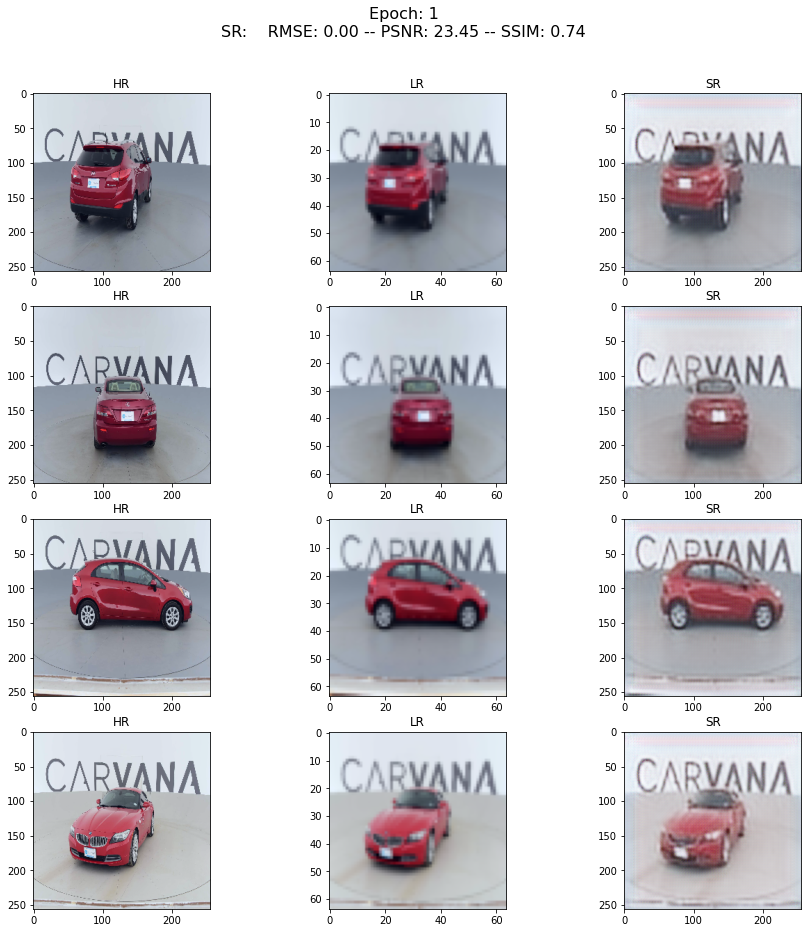

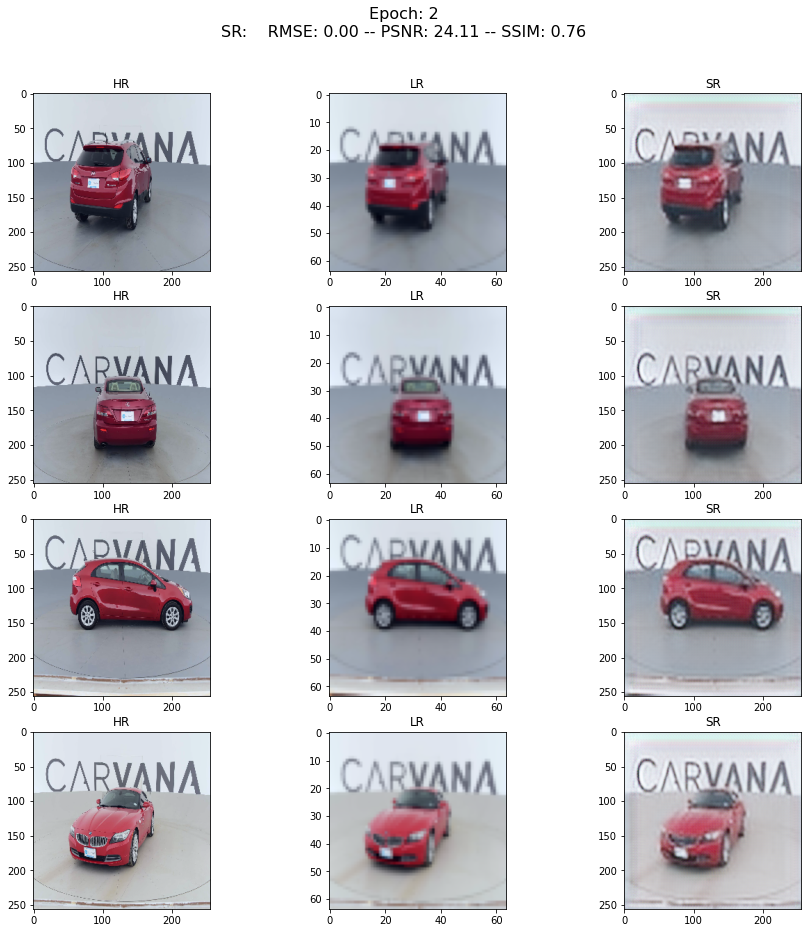

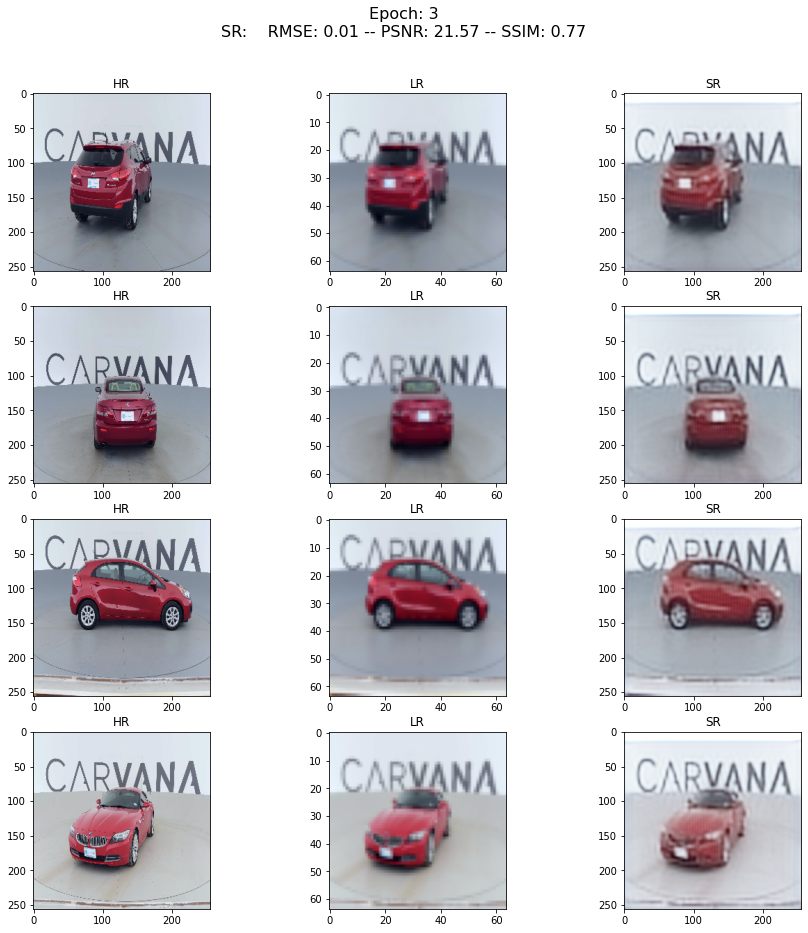

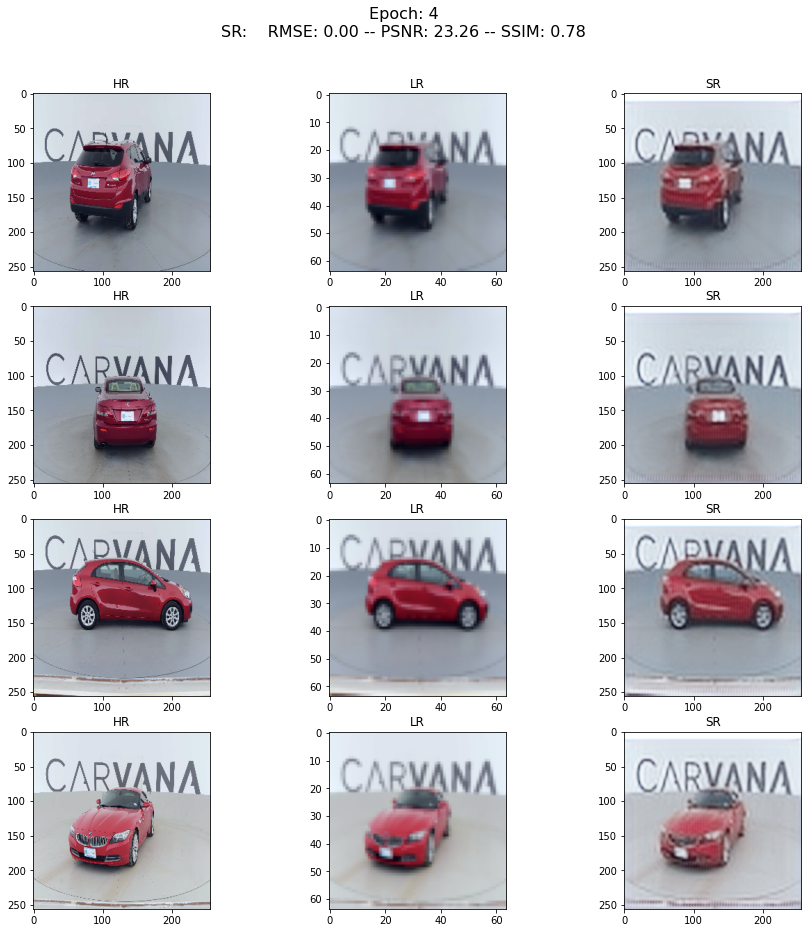

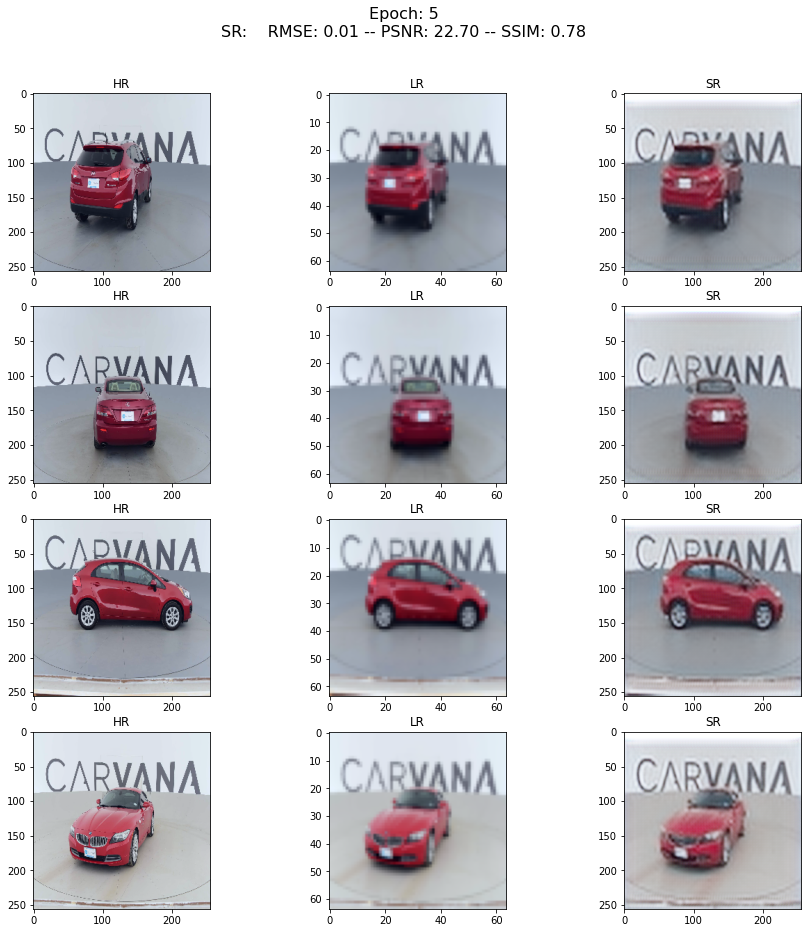

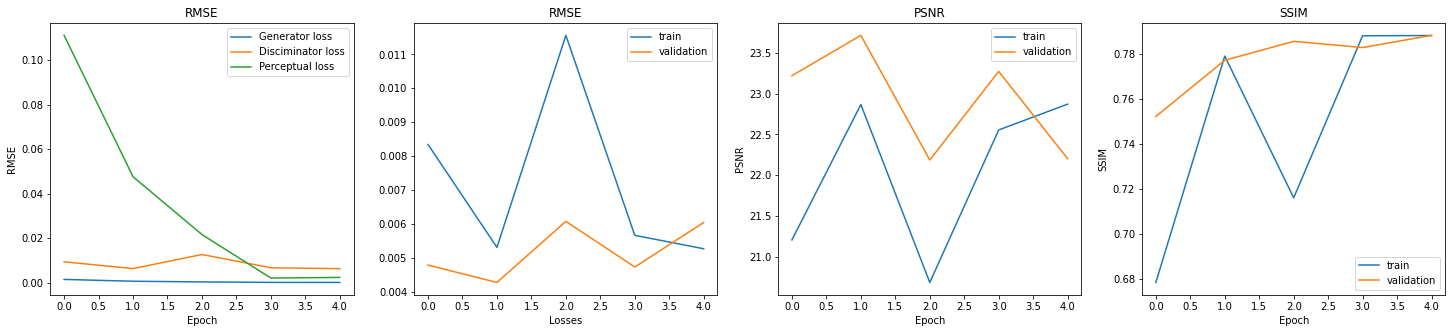

In [8]:
epochs = 5
bs = 4

# Se inicializan listas vacias en las que se almacenarán lás metricas de
# entrenamiento para cada epoch 
train_g_loss, train_d_loss, train_perc_loss, train_psnr, train_ssim, train_rmse = [], [], [], [], [], []

# Se inicializan listas vacias en las que se almacenarán lás metricas de
# validación para cada epoch
val_psnr, val_ssim, val_rmse = [], [], []

# Entrenamiento generador
for epoch in range(epochs) :

    with tqdm(train_dataloader,unit='batch') as tloader : 
        train_g_loss.append(train_generator(epoch,epochs,tloader))

# Entrenamiento y validación adversarial

for epoch in range(epochs) :

    with tqdm(train_dataloader,unit='batch') as tloader : 

        train_scores = train_adversarial(epoch,epochs,tloader)

        # Se almacenan las métricas en las listas correspondientes
        train_d_loss.append(train_scores[0])
        train_perc_loss.append(train_scores[1])
        train_psnr.append(train_scores[2])
        train_ssim.append(train_scores[3])
        train_rmse.append(train_scores[4])

        if epoch == 0:
            best_psnr_value = 0  
        is_best = train_psnr[epoch] > best_psnr_value
        best_psnr_value = max(train_psnr[epoch], best_psnr_value)
        if is_best:
            torch.save(discriminator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/saved_models/discriminator.pth")

    with tqdm(val_dataloader,unit='batch') as vloader : 
        val_scores = validate(vloader)

        # Se almacenan las métricas en las listas correspondientes
        val_psnr.append(val_scores[0])
        val_ssim.append(val_scores[1])
        val_rmse.append(val_scores[2])

        if epoch == 0:
            best_psnr_value = 0  
        is_best = val_psnr[epoch] > best_psnr_value
        best_psnr_value = max(val_psnr[epoch], best_psnr_value)
        if is_best:
            torch.save(generator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/saved_models/generator.pth")


# Plots
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
plt.title(f"RMSE")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.plot(train_g_loss, label='Generator loss')
plt.plot(train_d_loss, label='Disciminator loss')
plt.plot(train_perc_loss, label='Perceptual loss')
plt.legend()

plt.subplot(1,4,2)
plt.title(f"RMSE")
plt.xlabel('Losses')
plt.plot(train_rmse, label='train')
plt.plot(val_rmse, label='validation')
plt.legend()

plt.subplot(1,4,3)
plt.title(f"PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(train_psnr, label='train')
plt.plot(val_psnr, label='validation')
plt.legend()


plt.subplot(1,4,4)
plt.title(f"SSIM")
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(train_ssim, label='train')
plt.plot(val_ssim, label='validation')
plt.legend()